References:
- https://github.com/elisno/outlier_mnli/blob/main/outlier_mnli.ipynb
- https://towardsdatascience.com/understanding-outliers-in-text-data-with-transformers-cleanlab-and-topic-modeling-db3585415a19

In [87]:
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from cleanlab.outlier import OutOfDistribution
from umap import UMAP
from hdbscan import HDBSCAN

embeddings_location = '../page-embeddings.pkl'
outlier_scores_location = 'page-embeddings-outlier-scores.pkl'

with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

In [43]:
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=corpus_embeddings)

Fitting OOD estimator based on provided features ...


In [53]:
print(len(train_outlier_scores))

180783


In [44]:
# with open(outlier_scores_location, "wb") as writer:
#     pickle.dump({'scores': train_outlier_scores}, writer)

In [2]:
with open(outlier_scores_location, "rb") as reader:
    cache_data = pickle.load(reader)
    train_outlier_scores = cache_data['scores']

In [54]:
numpy_sections = np.array(sections)
numpy_embeddings = np.array(corpus_embeddings)

top_train_outlier_idxs = (train_outlier_scores).argsort()[:30]
outlier_sections = numpy_sections[top_train_outlier_idxs]

df = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df['score'] = train_outlier_scores[top_train_outlier_idxs]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,I’m trying to figure out how to get ground pec...,84,https://www.designbetter.co/conversations/jere...,Jeremy Faludi: exploring sustainable design be...,"Featuring Jeremy Faludi Assistant Professor, D...",0.526197
1,\nI tried to make my own sneakers. That was sh...,89,https://danmall.com/posts/2021-year-in-review/,"“2021 Year in Review,” an article by Dan Mall","Continuing the tradition from 2020, 2019, and ...",0.532256
2,Middle divider\nToothbrush$4.50Pinstriped corn...,68,https://mui.com/material-ui/react-divider/,React Divider component - Material UI,Divider A divider is a thin line that groups c...,0.532576
3,\n\n\n\n\n\n\nBeats Solo3 Wireless\nBeats Solo...,296,https://danmall.com/posts/should-you-use-boots...,“Should You Use Bootstrap or Material Design f...,Bootstrap and Material Design are incredibly t...,0.536293
4,What is it?\nPeople with vestibular disorders ...,201,https://www.a11yproject.com/posts/understandin...,Background: A primer to vestibular disorders -...,A primer to vestibular disorders Table of Cont...,0.538265
5,\nI played Wordle for 272 days straight. I mea...,44,https://danmall.com/posts/2022-year-in-review/,"“2022 Year in Review,” an article by Dan Mall","Continuing the tradition from 2021, 2020, 2019...",0.539974
6,They even had the audacity to send follow-up s...,208,https://bradfrost.com/blog/post/bradfrost-dot-...,bradfrost.com | Brad Frost,"bradfrost.com After 10 years, I finally secure...",0.541797
7,\n\nJames Baldwin\nAnyone who has ever struggl...,206,https://paste.twilio.design/components/table,Table - Paste: The Design System for building ...,"|Agents||Skills||Tasks| |Adam Brown||English, ...",0.542551
8,نجم هذا القرار عن دعوى قضائية في محكمة جزئية ...,264,https://build.washingtonpost.com/resources/acc...,WPDS - Semantic HTML and ARIA | Resources,Heading order and page landmarks Heading order...,0.542705
9,\nWhat is the air-speed velocity of an unladen...,186,https://clarity.design/documentation/wizards,Clarity Design System - Documentation - Wizards,Wizards provide a way to go through a sequence...,0.544265


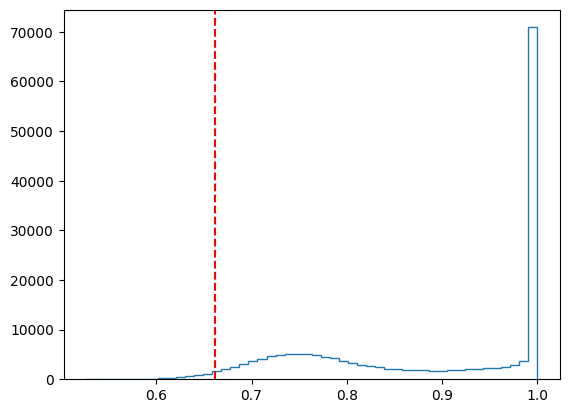

In [55]:
threshold = np.percentile(train_outlier_scores, 2.5)

plt_range = [train_outlier_scores.min(), train_outlier_scores.max()]

counts, bins = np.histogram(train_outlier_scores, range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)
plt.axvline(threshold, color='r', linestyle='--')

In [69]:
print(threshold)

0.6614402323961258


In [74]:
sorted_ids = train_outlier_scores.argsort()
scores = train_outlier_scores[sorted_ids]
outlier_ids = sorted_ids[scores < threshold]
rest_ids = sorted_ids[scores >= threshold]
anomaly_ids = sorted_ids[scores > 0.999]

outlier_sections = numpy_sections[outlier_ids]
outlier_embeddings = numpy_embeddings[outlier_ids]
outlier_scores = scores[outlier_ids]

rest_sections = numpy_sections[rest_ids]
rest_embeddings = numpy_embeddings[rest_ids]
rest_scores = scores[rest_ids]

anomaly_sections = numpy_sections[anomaly_ids]
anomaly_embeddings = numpy_embeddings[anomaly_ids]
anomaly_scores = scores[anomaly_ids]

df = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df['score'] = train_outlier_scores[outlier_ids]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,I’m trying to figure out how to get ground pec...,84,https://www.designbetter.co/conversations/jere...,Jeremy Faludi: exploring sustainable design be...,"Featuring Jeremy Faludi Assistant Professor, D...",0.526197
1,\nI tried to make my own sneakers. That was sh...,89,https://danmall.com/posts/2021-year-in-review/,"“2021 Year in Review,” an article by Dan Mall","Continuing the tradition from 2020, 2019, and ...",0.532256
2,Middle divider\nToothbrush$4.50Pinstriped corn...,68,https://mui.com/material-ui/react-divider/,React Divider component - Material UI,Divider A divider is a thin line that groups c...,0.532576
3,\n\n\n\n\n\n\nBeats Solo3 Wireless\nBeats Solo...,296,https://danmall.com/posts/should-you-use-boots...,“Should You Use Bootstrap or Material Design f...,Bootstrap and Material Design are incredibly t...,0.536293
4,What is it?\nPeople with vestibular disorders ...,201,https://www.a11yproject.com/posts/understandin...,Background: A primer to vestibular disorders -...,A primer to vestibular disorders Table of Cont...,0.538265
5,\nI played Wordle for 272 days straight. I mea...,44,https://danmall.com/posts/2022-year-in-review/,"“2022 Year in Review,” an article by Dan Mall","Continuing the tradition from 2021, 2020, 2019...",0.539974
6,They even had the audacity to send follow-up s...,208,https://bradfrost.com/blog/post/bradfrost-dot-...,bradfrost.com | Brad Frost,"bradfrost.com After 10 years, I finally secure...",0.541797
7,\n\nJames Baldwin\nAnyone who has ever struggl...,206,https://paste.twilio.design/components/table,Table - Paste: The Design System for building ...,"|Agents||Skills||Tasks| |Adam Brown||English, ...",0.542551
8,نجم هذا القرار عن دعوى قضائية في محكمة جزئية ...,264,https://build.washingtonpost.com/resources/acc...,WPDS - Semantic HTML and ARIA | Resources,Heading order and page landmarks Heading order...,0.542705
9,\nWhat is the air-speed velocity of an unladen...,186,https://clarity.design/documentation/wizards,Clarity Design System - Documentation - Wizards,Wizards provide a way to go through a sequence...,0.544265


In [6]:
# with open('outlier_embeddings.pkl', "wb") as writer:
#     pickle.dump({'sections': outlier_sections, 'embeddings': outlier_embeddings}, writer)

# with open('rest_embeddings.pkl', "wb") as writer:
#     pickle.dump({'sections': rest_sections, 'embeddings': rest_embeddings}, writer)

In [78]:
outlier_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
outlier_embeddings_umap = outlier_umap_fit.fit_transform(outlier_embeddings)

In [ ]:
df_outlier = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df_outlier['score'] = train_outlier_scores[outlier_ids]
df_outlier['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_outlier['x'] = outlier_embeddings_umap[:, 0]
df_outlier['y'] = outlier_embeddings_umap[:, 1]
df_outlier['z'] = outlier_embeddings_umap[:, 2]
df_outlier['domain'] = df_outlier['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_outlier, x='x', y='y', z='z',
    color=df_outlier.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_outlier.sample(10)

In [ ]:
clusterer_outlier_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_outlier_embeddings_umap = clusterer_outlier_umap_fit.fit_transform(outlier_embeddings)

clusterer_outlier = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_outlier.fit(clusterer_outlier_embeddings_umap)

In [ ]:
plt.figure(figsize=(10, 10))

outlier_x_plot, outlier_y_plot = clusterer_outlier_embeddings_umap[:, 0], clusterer_outlier_embeddings_umap[:, 1]
outlier_domain_labels = {k: v for v, k in enumerate(df_outlier['domain'].unique())}
outlier_assigned_labels = np.array([outlier_domain_labels.get(x, 0) for x in df_outlier['domain']])

for i, domain in enumerate(df_outlier['domain'].unique()):
    x, y = outlier_x_plot[outlier_assigned_labels == i], outlier_y_plot[outlier_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_outlier_labels = clusterer_outlier.labels_
clusterer_outlier.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_outlier_labels):
    if i != -1:
        x, y = outlier_x_plot[clusterer_outlier_labels == i], outlier_y_plot[clusterer_outlier_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = outlier_x_plot[clusterer_outlier_labels == -1], outlier_y_plot[clusterer_outlier_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()

In [ ]:
rest_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
rest_embeddings_umap = rest_umap_fit.fit_transform(rest_embeddings)

In [ ]:
df_rest = pd.DataFrame.from_records(pd.json_normalize(rest_sections, sep='_'))
df_rest['score'] = train_outlier_scores[rest_ids]
df_rest['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_rest['x'] = rest_embeddings_umap[:, 0]
df_rest['y'] = rest_embeddings_umap[:, 1]
df_rest['z'] = rest_embeddings_umap[:, 2]
df_rest['domain'] = df_rest['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_rest, x='x', y='y', z='z',
    color=df_rest.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_rest.sample(10)

In [ ]:
clusterer_rest_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_rest_embeddings_umap = clusterer_rest_umap_fit.fit_transform(rest_embeddings)

clusterer_rest = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_rest.fit(clusterer_rest_embeddings_umap)

In [ ]:
plt.figure(figsize=(10, 10))

rest_x_plot, rest_y_plot = clusterer_rest_embeddings_umap[:, 0], clusterer_rest_embeddings_umap[:, 1]
rest_domain_labels = {k: v for v, k in enumerate(df_rest['domain'].unique())}
rest_assigned_labels = np.array([rest_domain_labels.get(x, 0) for x in df_rest['domain']])

for i, domain in enumerate(df_rest['domain'].unique()):
    x, y = rest_x_plot[rest_assigned_labels == i], rest_y_plot[rest_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_rest_labels = clusterer_rest.labels_
clusterer_rest.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_rest_labels):
    if i != -1:
        x, y = rest_x_plot[clusterer_rest_labels == i], rest_y_plot[clusterer_rest_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = rest_x_plot[clusterer_rest_labels == -1], rest_y_plot[clusterer_rest_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()

In [ ]:
anomaly_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
anomaly_embeddings_umap = anomaly_umap_fit.fit_transform(anomaly_embeddings)

In [ ]:
df_anomaly = pd.DataFrame.from_records(pd.json_normalize(anomaly_sections, sep='_'))
df_anomaly['score'] = train_outlier_scores[anomaly_ids]
df_anomaly['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_anomaly['x'] = anomaly_embeddings_umap[:, 0]
df_anomaly['y'] = anomaly_embeddings_umap[:, 1]
df_anomaly['z'] = anomaly_embeddings_umap[:, 2]
df_anomaly['domain'] = df_anomaly['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_anomaly, x='x', y='y', z='z',
    color=df_anomaly.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_anomaly.sample(10)

In [ ]:
clusterer_anomaly_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_anomaly_embeddings_umap = clusterer_anomaly_umap_fit.fit_transform(anomaly_embeddings)

clusterer_anomaly = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_anomaly.fit(clusterer_anomaly_embeddings_umap)

In [ ]:
plt.figure(figsize=(10, 10))

anomaly_x_plot, anomaly_y_plot = clusterer_anomaly_embeddings_umap[:, 0], clusterer_anomaly_embeddings_umap[:, 1]
anomaly_domain_labels = {k: v for v, k in enumerate(df_anomaly['domain'].unique())}
anomaly_assigned_labels = np.array([anomaly_domain_labels.get(x, 0) for x in df_anomaly['domain']])

for i, domain in enumerate(df_anomaly['domain'].unique()):
    x, y = anomaly_x_plot[anomaly_assigned_labels == i], anomaly_y_plot[anomaly_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_anomaly_labels = clusterer_anomaly.labels_
clusterer_anomaly.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_anomaly_labels):
    if i != -1:
        x, y = anomaly_x_plot[clusterer_anomaly_labels == i], anomaly_y_plot[clusterer_anomaly_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = anomaly_x_plot[clusterer_anomaly_labels == -1], anomaly_y_plot[clusterer_anomaly_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()